In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from constants import Column
from helper_fun import fit, add_covariates, reformat_dict, plot_confusion_matrices, get_grid,find_tile_adjacent_to_nan
import numpy as np
import json
import mplscience
import seaborn as sns
mplscience.available_styles()
mplscience.set_style(reset_current=True)

model_name = {
              'mcVAE': 'ctvae-conditional_wasserstein8_fxk3lmiz',
              'cellprofiler_pca': 'singlecell_ipca_fixederror_128pc',
              }

# ensures notebook gets updated immediately when src files change
%load_ext autoreload
%autoreload 2

['default', 'despine']


### Load metadata to predict

In [2]:
metadata = pd.read_pickle('/home/wangz222/scratch/splits_shuffled/filtered_df.pkl')
metadata[Column.tile.value] = metadata[Column.tile.value].astype('int64')
metadata = add_covariates(metadata)

center    3093935
edge      2638396
Name: fov_position, dtype: int64


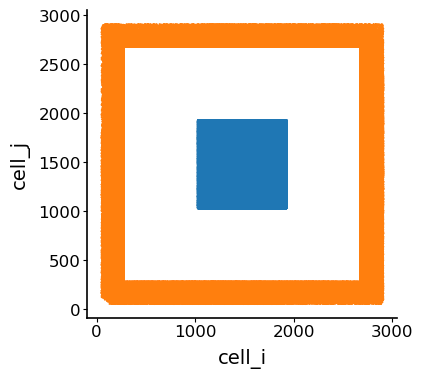

In [3]:
#plot the fov position
data_temp = metadata[~metadata['fov_position'].isna()].loc[::3,:]
sns.scatterplot(data = data_temp, x='cell_i', y='cell_j', hue='fov_position', s=2, legend=False, edgecolor='none')
# plt.savefig('figure/figure_2/fov_position.png', dpi=400)
plt.show()

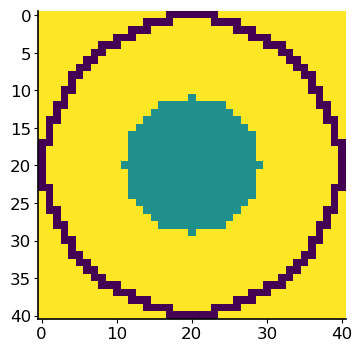

In [4]:
disk = get_grid('6W_ph')
edge_tiles, center_tiles = find_tile_adjacent_to_nan(disk)
disk[np.isin(disk, edge_tiles.astype(int))] = 0
disk[np.isin(disk, center_tiles.astype(int))] = 1
disk[np.isnan(disk)] = 2
disk[disk>2] = 2
plt.imshow(disk)
# plt.savefig('figure/figure_2/well_position.png', dpi=300)
plt.show()

### load embedding as predictor

In [5]:
fname = model_name['mcVAE']
embedding = pd.read_pickle(f'/home/wangz222/scratch/embedding/{fname}.pkl')
print(f'Number of cells {len(embedding)}')

Number of cells 23625194


In [6]:
#check the metadatas match
print(metadata[[Column.sgRNA.value, Column.gene.value]].equals(embedding[[Column.sgRNA.value, Column.gene.value]]))

ntc_metadata = metadata[metadata[Column.gene.value] == 'nontargeting']
ntc_embedding = embedding[metadata[Column.gene.value] == 'nontargeting']
ntc_salient, ntc_background = ntc_embedding.iloc[:,2:34], ntc_embedding.iloc[:,34:]

True


### load cell profiler features

In [22]:
fname = model_name['cellprofiler_pca']
cp_data = pd.read_parquet('/gstore/data/ctgbioinfo/kudot3/romain/cellprofiler_128pc.parquet', engine='pyarrow')
# subset to only rows from same batches as those in our vae metadata
cp_data = cp_data[(cp_data[Column.plate.value]+cp_data[Column.well.value]).isin(metadata[Column.batch.value].unique())].reset_index(drop=True)
cp_data.rename(columns={"class_predict_1": Column.cell_cycle_stage.value}, inplace=True)

In [12]:
cp_data.to_parquet('/home/wangz222/scratch/embedding/cellprofiler/cellprofiler_128pc.parquet', compression='snappy')

In [8]:
# combine metadata with cellprofiler PCs
metadata = metadata.merge(cp_data, on=['cell_i', 'cell_j', Column.plate.value, Column.well.value, Column.gene.value, Column.tile.value, Column.cell_cycle_stage.value, Column.sgRNA.value], how='left')
# subset to only nontargeting
ntc_metadata = metadata[metadata[Column.gene.value] == 'nontargeting']

# splitting into features and metadata
pc_col = [f'PC{i}' for i in range(64)]
cp_embedding = metadata[pc_col]
metadata = metadata.drop(columns=[col for col in metadata.columns if col.startswith('PC')])
ntc_cp_embedding = ntc_metadata[pc_col]
ntc_metadata = ntc_metadata.drop(columns=[col for col in ntc_metadata.columns if col.startswith('PC')])

### Fit logistic regression model against different covariates

In [ ]:
embed_df = {'salient': ntc_salient, 'background': ntc_background, 
            'combined': ntc_embedding.iloc[:,2:], 'CellProfiler (batch corrected)': ntc_cp_embedding}
covariates = [Column.batch.value, 'fov_position', 'well_position']
# Train a model for specific covariates in metadata
median_metric = {key:{key_2:None for key_2 in covariates} for key in embed_df.keys()}
mad_metric = {key:{key_2:None for key_2 in covariates} for key in embed_df.keys()}
for embed_name in embed_df.keys():
    for column in covariates:
        median, mad = fit(embed_df[embed_name], ntc_metadata, column, average='macro')
        median_metric[embed_name][column] = median
        mad_metric[embed_name][column] = mad

#reformat for plotting
metric_name = ['auroc', 'precision', 'recall', 'f1', 'accuracy', 'confusion_matrix']
reformat_median = reformat_dict(median_metric, metric_name)
reformat_mad = reformat_dict(mad_metric, metric_name)

### plot logistic regression results

In [ ]:
measure = 'f1'
df_median = pd.DataFrame(reformat_median[measure], index=covariates)
df_mad = pd.DataFrame(reformat_mad[measure], index=covariates)

df_median.plot(kind='bar') 
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.xlabel('non-biological covariates', fontsize=15)
plt.ylabel("F1 score", fontsize=15)

# Show a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
# plt.title('Linear separability of NTC covariates in various embedding spaces', fontsize=14)
# Show the plot
ax.set_xticklabels(['batch', 'position \nin FOV', 'position \nin well'], rotation=0, fontsize=12)
plt.savefig(f'figure/figure_2/linear_separability_{measure}.svg', bbox_inches='tight')  # Save the plot with the desired DPI
plt.show()

In [ ]:
measure = 'auroc'
df_median = pd.DataFrame(reformat_median[measure], index=covariates)
df_mad = pd.DataFrame(reformat_mad[measure], index=covariates)

df_median.plot(kind='bar') 
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
# plt.xlabel('non-biological covariates', fontsize=15)
plt.ylabel("AUROC", fontsize=15)

# Show a legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
# plt.title('Linear separability of NTC covariates in various embedding spaces', fontsize=14)
# Show the plot
ax.set_xticklabels(['batch', 'position \nin FOV', 'position \nin well'], rotation=0, fontsize=12)
plt.savefig(f'figure/figure_2/linear_separability_{measure}.svg', bbox_inches='tight')  # Save the plot with the desired DPI
plt.show()

### Fit linear regression against shape and cell size features

In [ ]:
embed_df = {'salient': ntc_salient, 'background': ntc_background, 
            'salient+background': ntc_embedding.iloc[:,2:]}
covariates = ['cell_median_radius']
# Train a model for specific covariates in metadata
median_metric = {key:{key_2:None for key_2 in covariates} for key in embed_df.keys()}
mad_metric = {key:{key_2:None for key_2 in covariates} for key in embed_df.keys()}
for embed_name in embed_df.keys():
    for column in covariates:
        median, mad = fit(embed_df[embed_name], ntc_metadata, column)
        median_metric[embed_name][column] = median
        mad_metric[embed_name][column] = mad

#reformat for plotting
metric_name = ['r2', 'explained_variance']
reformat_median = reformat_dict(median_metric, metric_name)
reformat_mad = reformat_dict(mad_metric, metric_name)

### plot linear regression result

In [ ]:
measure = 'explained_variance'
colors = ['tab:green', 'tab:orange', 'dimgray'] 

df_median = pd.DataFrame(reformat_median[measure], index=covariates)
df_mad = pd.DataFrame(reformat_mad[measure], index=covariates)

df_median.plot(kind='bar', yerr=df_mad, figsize=(2, 4), color=colors) 
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('cell median radius', fontsize=14)
plt.ylabel('variance explained', fontsize=14)
plt.xticks(rotation=0)

# Show a legend
plt.legend(frameon=False, bbox_to_anchor=(1.05, 1), fontsize=13)
# plt.title('Linear predictability of cell shape/size covariates in various embedding spaces', fontsize=14)
# Show the plot
ax.set_xticklabels([''], rotation=0)
plt.savefig(f'figure/shape_variance.svg', dpi=300, bbox_inches='tight')  # Save the plot with the desired DPI
plt.show()

#### Predicting gene function using embedding

In [3]:
# Open the json file
with open('KEGG_modified_cluster.json', 'r') as file:
    gene_function = json.load(file)
# for key, value in list(gene_function.items()):
#     if value == 'Actin cytoskeleton & Adhesion':
#         gene_function[key] = 'Actin/Adhesion'
#     elif value == 'General transcription factors, mRNA export':
#         gene_function[key] = 'General TF'
#     elif value == 'Translation initiation & tRNA ligases':
#         gene_function[key] = 'Translation'

In [4]:
unrelated_genes = ['FAU', 'RCL1', 'DHX37', 'EIF3I', 'NOB1', 'LTV1', 'EIF3B', 'UTP11', 'DDX10', 'IMP4', 
                   'BUD23', 'NOL6', 'EIF3CL', 'FCF1', 'UTP3', 'EIF3A', 'HSPA5', 'PNO1']+['CEBPZ', 'METAP2',
                    'PPAN', 'AAMP']+['EEF2']+['NAA50']+ ['GAPDH', 'KRT8', 'KRT18', 'KRTAP4-2', 'MT1G', 'MT1E',
                     'MT2A', 'FOXD4L5', 'FOXD4L1']+['NDUFA4', 'ATP5PB', 
                'KRTAP2-2']+['ATR']+['NACA']+['PIK3CA']+['DHFR']+['HK2']+['PSMD11','PSMD8','PSMD3','PSMD7',
               'PSMD1','PSMD12']+['POLD3']+["SLC20A1"]+['"HMGCR"']+['KPNB1', 'SEC61G', 
               'SEC61A1', 'CSE1L', 'RBM8A', 'MCRS1','KAT8','SRRT','TLK2', 'SFPQ', 'RANBP2',
                        'DDX3X', 'NCBP1', 'NCBP2', 'KANSL1', 'KANSL2', 'KANSL3']+['COP1', 'RANBP2', 'RANGAP1', 'XPO1', 'NUP88', 'NUP214', 'NUTF2']
for key in unrelated_genes:
    gene_function.pop(key, None)

In [7]:
with open('modified_functional_clusters.json', 'w') as file:
    json.dump(gene_function, file)

In [11]:
cp_embedding_select = cp_embedding[metadata[Column.gene.value].isin(gene_function.keys())]
embedding_select = embedding[metadata[Column.gene.value].isin(gene_function.keys())]
metadata_select = metadata[metadata[Column.gene.value].isin(gene_function.keys())]

# Add the function column
metadata_select['function'] = metadata_select[Column.gene.value].map(gene_function)

# p-value from univariate test using cell profiler features
cp_univariate = pd.read_parquet('funk22-cellprofiler-univariate-ipca90.parquet')
SIG_sgRNA = list(cp_univariate.loc[cp_univariate['pvalue']<0.01, 'sgRNA_0'])
nonSIG_ntcsgRNA = list(cp_univariate.loc[(cp_univariate['pvalue']>0.05) & (cp_univariate[Column.gene.value]=='nontargeting'), 'sgRNA_0'])

/tmp/ipykernel_448395/1065313736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_select['function'] = metadata_select[Column.gene.value].map(gene_function)


In [ ]:
cp_embedding_select.loc[:,'sgRNA_0'] = metadata_select['sgRNA_0']

In [ ]:
# filter out gRNAs with low inconsistency
embedding_filtered = embedding_select[metadata_select[Column.sgRNA.value].isin(SIG_sgRNA)]
cp_embedding_filtered = cp_embedding_select[metadata_select[Column.sgRNA.value].isin(SIG_sgRNA)]
metadata_filtered = metadata_select[metadata_select[Column.sgRNA.value].isin(SIG_sgRNA)]

# aggregate to gRNA level
agg_embedding = embedding_filtered.groupby(Column.sgRNA.value).mean()
agg_metadata = metadata_filtered.groupby(Column.sgRNA.value).first()
agg_cp_embedding = cp_embedding_filtered.groupby(Column.sgRNA.value).mean()

# split into salient and background
salient, background = agg_embedding.iloc[:,:32], agg_embedding.iloc[:,32:]

In [ ]:
import umap

# Fit UMAP model to the data
reducer = umap.UMAP()
embedding = reducer.fit_transform(agg_embedding)

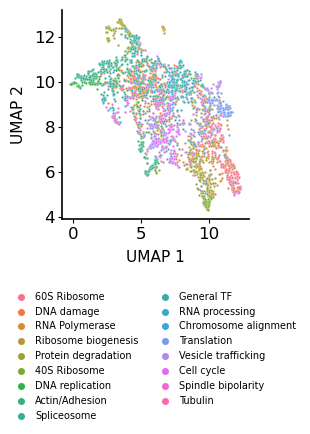

In [37]:
# Plot the UMAP results
plt.figure(figsize=(3, 5))
umap_df = pd.DataFrame(embedding, columns=['x', 'y'])
umap_df['function'] = agg_metadata['function'].reset_index(drop=True)
# sns.scatterplot(data=umap_df, x='x', y='y', hue='function', s=3, cmap='Spectral', legend='auto')
# Get unique function labels
functions = umap_df['function'].unique()
palette = sns.color_palette("husl", len(functions))
# Iterate over unique function labels and plot each group separately
for i, function in enumerate(functions):
    subset = umap_df[umap_df['function'] == function]
    sns.scatterplot(data=subset, x='x', y='y', s=3, label=function, color=palette[i]) # Include label parameter


plt.xlabel('UMAP 1', fontsize=11)
plt.ylabel('UMAP 2', fontsize=11)
plt.legend(bbox_to_anchor=(0.5, -0.3), loc='upper center', ncol=2, labels=umap_df['function'].unique(), fontsize=7, markerscale=3, scatterpoints=1)
plt.tight_layout() # Adjusts the layout so that the legend fits into the figure
plt.savefig('figure/figure_3/umap_combined.svg', bbox_inches='tight')
plt.show()

In [ ]:
embed_df = {'salient': salient, 'background': background, 'combined': agg_embedding, 'cellprofiler': agg_cp_embedding}
# Train a model for select covariates in metadata
metric = {key:None for key in embed_df.keys()}
for embed_name in embed_df.keys():
    output, _ = fit(embed_df[embed_name], agg_metadata, 'function', average=None)
    metric[embed_name] = output  
#reformat for plotting
metric_name = ['auroc', 'precision', 'recall', 'f1', 'accuracy', 'confusion_matrix']
reformat_metric = {name:{df_name:val[name] for df_name, val in metric.items()} for name in metric_name}

In [ ]:
# measure = 'f1'
# unique_labels = sorted(set(list(agg_metadata['function'])))
# df_metric = pd.DataFrame(reformat_metric[measure], index=unique_labels)

# df_metric.plot(kind='bar') 
# ax = plt.gca()
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Only show ticks on the left and bottom spines
# plt.xlabel('functional gene groups', fontsize=14)
# plt.ylabel(measure, fontsize=14)

# # Show a legend
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
# plt.title('Classifying gene function using various embedding spaces', fontsize=14)
# # Show the plot
# ax.set_xticklabels(unique_labels, rotation=90)
# # plt.savefig(f'gene_function_{measure}.svg', bbox_inches='tight')  # Save the plot with the desired DPI
# plt.show()

# print(unique_labels) 

In [ ]:
# # # Example usage with dictionary:
plot_confusion_matrices(reformat_metric['confusion_matrix'], classes=unique_labels, normalize=True)

In [ ]:
# Determine the colors for each bar
diff_mat = (reformat_metric['confusion_matrix']['background']/reformat_metric['confusion_matrix']['background'].sum(axis=1)-
            reformat_metric['confusion_matrix']['salient']/reformat_metric['confusion_matrix']['salient'].sum(axis=1))

data = np.diagonal(diff_mat)

# Sort both unique_labels and data by data in descending order
sorted_data, sorted_labels = zip(*sorted(zip(data, unique_labels), reverse=False))
colors = ['tab:orange' if value >= 0 else 'tab:green' for value in sorted_data]
# Create the horizontal bar plot
plt.barh(sorted_labels, sorted_data, color=colors)


# plt.barh(unique_labels[::-1], data[::-1], color=colors[::-1])
# Add a horizontal line through 0
plt.axvline(x=0, color='black')

# Remove all the borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Remove y-axis ticks if you don't want them
plt.xlabel('Difference in recall', fontsize=13)
# plt.yticks([])
# plt.xticks([])

# Show the plot
plt.savefig('figure/delta_recall.svg', bbox_inches='tight')
plt.show()

### visualizing tubulina and actin cytoskeleton/adhesion in PCA space

In [ ]:
embed_subset = embedding_filtered[(metadata_filtered['function'].isin(['Tubulin', 'Actin cytoskeleton & Adhesion']))]
metadata_subset = metadata_filtered[(metadata_filtered['function'].isin(['Tubulin', 'Actin cytoskeleton & Adhesion']))]
ntc_embed_subset = ntc_embedding.iloc[::3,:]
ntc_metadata_subset = ntc_metadata.iloc[::3,:]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separate out the features
df_temp = pd.concat([embed_subset,ntc_embed_subset])
X = df_temp.iloc[:,2:].values
df_temp['batch'] = pd.concat([metadata_subset['batch'],ntc_metadata_subset['batch']], ignore_index=True)

# Standardize the features
X = StandardScaler().fit_transform(X)
def standardize_features(group):
    scaler = StandardScaler()
    group = scaler.fit_transform(group)
    return group

df_standardized = df_temp.iloc[:,2:].groupby('batch').apply(standardize_features)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

principal_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
principal_df['label'] = pd.concat([metadata_subset['function'],ntc_embed_subset[Column.gene.value]], ignore_index=True).values
principal_df.groupby(['label']).count()

In [ ]:
import seaborn as sns

labels_order = ['Actin cytoskeleton & Adhesion', 'nontargeting', 'Tubulin']
principal_df['label'] = principal_df['label'].astype('category')
principal_df['label'].cat.set_categories(labels_order, ordered=True, inplace=True)
principal_df.sort_values('label', inplace=True)

plt.figure(figsize=(8, 6))
g = sns.JointGrid(data=principal_df, x='PC1', y='PC2', hue='label')
g = g.plot_joint(sns.kdeplot, fill=True) 
g = g.plot_marginals(sns.kdeplot, fill=True, common_norm=False)
plt.show()


### make scatter plot of features coloring genes in actin cytoskeleton and adhesion

In [ ]:
agg_shape_feature = metadata_filtered.groupby(Column.gene.value)[['function','cell_perimeter', 'cell_eccentricity']].agg({
    'function': 'first',  # Get the first value in 'value1' for each group
    'cell_eccentricity': 'mean',
    'cell_perimeter': 'mean' 
}).reset_index()

colors = ['tab:red' if fun == 'Actin cytoskeleton & Adhesion' else 'gray' 
          if fun == 'nontargeting' else 'tab:blue' for fun in agg_shape_feature['function']]

plt.figure(dpi=200)
plt.scatter(agg_shape_feature['cell_perimeter'], agg_shape_feature['cell_eccentricity'], s=8, alpha=0.8, 
            color=colors, label=agg_shape_feature['function'])
plt.xlabel('Cell Perimeter', fontsize=14)
plt.ylabel('Cell Eccentricity', fontsize=14)
#remove top and right borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()